# LAB TEST


## 0. Setting

In [1]:
pwd

'/content'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Outlier Detection Paper'

/content/drive/MyDrive/Outlier Detection Paper


In [4]:
!ls

 영석		 Figure		   oc_svm_model_save
'논문 작업'	'LAB TEST.ipynb'  'Outlier Detection Final.ipynb'
'준혁 옛날 거'	'low version'	   Reference
 data		 lstm_model_save


### Library Call

In [ ]:
# 상용 라이브러리
from glob import glob
import os
import pandas as pd
import numpy as np
from datetime import datetime
import time
import pickle

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# Sckit-Learn 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, plot_roc_curve

# Statistic Tools 라이브러리
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.cluster.hierarchy import dendrogram, linkage

# Tensorflow 라이브러리
import tensorflow as tf
from tensorflow import keras

### User Function Definition

In [ ]:
# BoxplotEDA Function Definition
def boxplotEDA(data,cols,nrow,ncol,title):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,5*nrow))
  plt.suptitle(title,y=0.92,size=30)
  i=0
  for col in cols:
    sns.boxplot(y = df[col], ax=ax[i//ncol,i%ncol], palette='Set3', linewidth=1.5)
    i+=1  

# Sublineplot
def subplots(data,cols,nrow,ncol,title):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(8*ncol,5*nrow))
  plt.suptitle(title, y=0.92, size=30)
  i=0
  for col in cols:
    ax[i//ncol,i%ncol].plot(np.arange(data.shape[0]),df[col])
    ax[i//ncol,i%ncol].set_ylabel(col)
    i+=1  
  
# lineplot
def lineplot(data,cols,title):
  df = data[cols]
  plt.figure(figsize=(16,8))
  plt.title(title, y=1.05, size=25)
  for col in cols:
    plt.plot(np.arange(data.shape[0]),df[col], label=col)
  plt.legend(loc='upper right')  

# corr_matrix
def corr_matrix(data, cols, title):
  df = data[cols]
  colormap = plt.cm.PuBu 
  plt.figure(figsize=(12, 12)) 
  plt.title(title, y=1.05, size=20)
  sns.heatmap(df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
              square = True, cmap = colormap, linecolor = "white", annot = True, fmt='.2f',
              annot_kws = {"size" : 12})
  plt.show()

# IQR Based Outlier Processing Function Definition
def outliers_iqr(data):
  q1,q3 = np.percentile(data,[25,75])
  iqr=q3-q1
  lower_bound=  q1 - (iqr *1.5)
  upper_bound = q3 + (iqr *1.5)
  data[data>upper_bound] = np.nan #np.mean(data)
  data[data<lower_bound] = np.nan #np.mean(data)
  data.interpolate(method="ffill", inplace=True)
  data.interpolate(method="bfill", inplace=True)
  return data

# Reconstruction Error Computation Function
def RE_SCORE(X_input, X_pred):
    score = pd.DataFrame(index = X_pred.index)
    score['RE_SCORE'] = np.mean(np.square(X_input-X_pred),axis=1)
    return score

# Simulation Data Cleansing Function Definition
def simul_cleansing(df):
  df = df[['TsYMD','Temperature','Humidity','TVOC','CO','CO2','CH2O','PM10']]
  df['TsYMD'] = pd.to_datetime(df['TsYMD'])
  df = df.sort_values('TsYMD')
  df['TsYMD'] = df['TsYMD'].dt.to_period(freq='min')
  df.rename(columns={'TsYMD':'Time'},inplace=True)
  time =df['Time'].apply(lambda x: x.strftime('%Y%m%d%H%M'))
  df.index = df['Time']
  df.drop('Time',axis=1,inplace=True)
  return df

# 여러 분류 지표 출력
def get_clf_eval(y_test,pred):
    cf = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    rec = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    
    print(cf)
    print('정확도 :{0:.4f}, 정밀도 :{1:.4f}, 재현율 :{2:.4f}, F1 :{3:.4f}'.format(acc,pre,rec,f1))
#     return [acc, pre, rec, f1]

## 1. Simulation Data Load

In [ ]:
# device08_0713_0720.csv preprocessed data
simul_df = pd.read_csv('data/simul_label.csv',index_col='Time')
simul_label = simul_df['label']
simul_df = simul_df.drop('label',axis=1)
print('simul_df.shape :',simul_df.shape)
simul_df.head(2)

simul_df.shape : (4581, 7)


,Temperature,Humidity,TVOC,CO,CO2,CH2O,PM10
Time,,,,,,,
2022-07-13 0:01,22.63,36.52,2424,0.69,600,55,5
2022-07-13 0:03,22.64,36.55,2421,0.70,602,55,5


In [ ]:
simul_df.tail(2)

,Temperature,Humidity,TVOC,CO,CO2,CH2O,PM10
Time,,,,,,,
2022-07-19 8:44,23.74,37.11,4268,0.73,724,66,13
2022-07-19 8:46,23.75,35.96,4027,0.75,700,57,13


In [ ]:
simul_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4581 entries, 2022-07-13 0:01 to 2022-07-19 8:46
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  4581 non-null   float64
 1   Humidity     4581 non-null   float64
 2   TVOC         4581 non-null   int64  
 3   CO           4581 non-null   float64
 4   CO2          4581 non-null   int64  
 5   CH2O         4581 non-null   int64  
 6   PM10         4581 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 286.3+ KB


In [ ]:
# MissingValue Check
print('Missing Value :',simul_df.isna().sum().sum())

Missing Value : 0


In [ ]:
# definite simul size
simul_size = simul_df.shape[0]

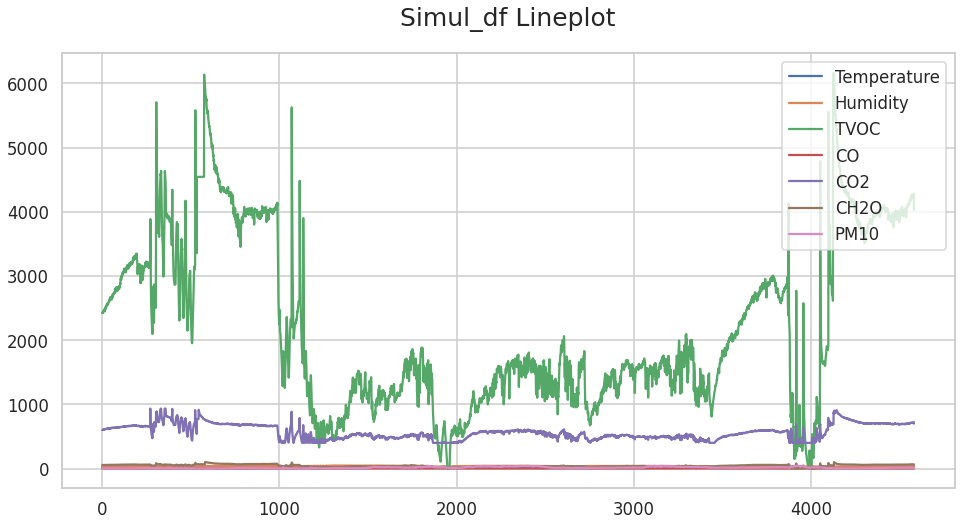

In [ ]:
# Simul Data Lineplot
lineplot(simul_df, simul_df.columns, 'Simul_df Lineplot')

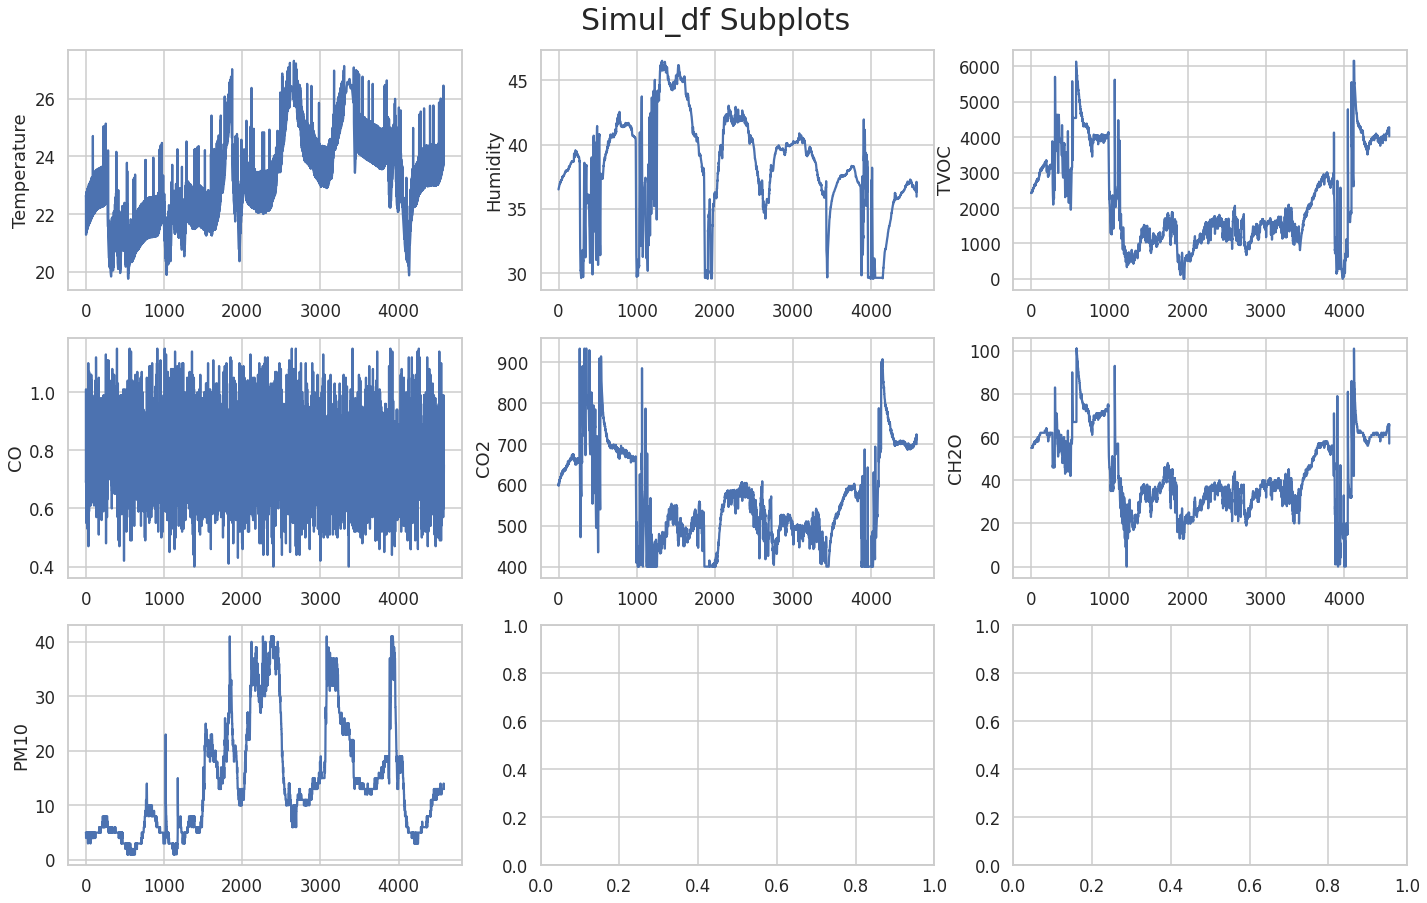

In [ ]:
# Simul Data Subplots
subplots(simul_df,simul_df.columns,3,3,'Simul_df Subplots')

In [ ]:
# Siumul Data Label
label_freq = simul_label.value_counts()
label_freq

0    4461
1      54
5      25
2      19
3      11
4      11
Name: label, dtype: int64

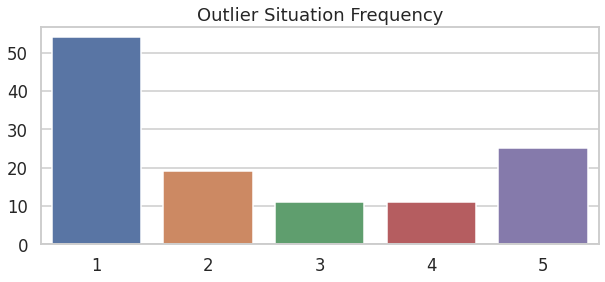

In [ ]:
# Outlier Situation Frequency
plt.figure(figsize=(10,4))
sns.barplot(label_freq.index[1:], label_freq.values[1:])
plt.title('Outlier Situation Frequency',size=18)
plt.show()

In [ ]:
# y_label Definition ['Normal','Outlier']
y_label = np.array(['Normal','Outlier'])[(simul_label != 0).astype(int)]
y_label = pd.Series(y_label, simul_df.index)
y_label.value_counts()

Normal     4461
Outlier     120
dtype: int64

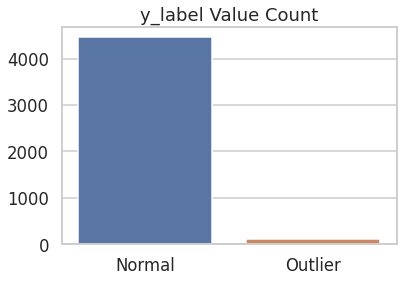

In [ ]:
# y_label Value Count Visualization
plt.figure(figsize=(6,4))
sns.barplot(y_label.value_counts().index, y_label.value_counts().values)
plt.title('y_label Value Count',size=18)
plt.show()

In [ ]:
# Actual Outlier Distribution : TVOC
fig = px.scatter(x=simul_df.index, y=simul_df['TVOC'], title='# Actual Outlier Distribution : TVOC', color=y_label)
fig

In [ ]:
# Actual Outlier Distribution : CO2
fig = px.scatter(x=simul_df.index, y=simul_df['CO2'], title='# Actual Outlier Distribution : CO2', color=y_label)
fig

## 2. Simulation Data Preprocessing

In [ ]:
# Simulation Data MinMaxScaling
simul_norm = MinMaxScaler()
X_simul = simul_norm.fit_transform(simul_df)
print('X_simul.shape :',X_simul.shape)

X_simul.shape : (4581, 7)


In [ ]:
# Original Simulation DataSet
og_simul = pd.DataFrame(X_simul, columns = simul_df.columns)
og_simul.index = simul_df.index
og_simul.head(3)

,Temperature,Humidity,TVOC,CO,CO2,CH2O,PM10
Time,,,,,,,
2022-07-13 0:01,0.380449,0.410029,0.393570,0.386667,0.374532,0.544554,0.1
2022-07-13 0:03,0.381770,0.411799,0.393083,0.400000,0.378277,0.544554,0.1
2022-07-13 0:05,0.202114,0.413569,0.394707,0.813333,0.370787,0.544554,0.1


In [ ]:
# Simulation Data Windowing
X_simul_window = np.reshape(X_simul, (-1,3,7))
print('X_simul_window.shape :',X_simul_window.shape)

X_simul_window.shape : (1527, 3, 7)


## 3. Simulation Data Reconstruction

In [ ]:
# LSTM-AE Model Load
lstm_ae_model = keras.models.load_model('lstm_model_save/lstm_ae_0712_t3/')
encoder = keras.models.load_model('lstm_model_save/encoder_0712_t3/')
decoder = keras.models.load_model('lstm_model_save/decoder_0712_t3/')

In [ ]:
# Prediction of Simul DataSet
X_temp = lstm_ae_model.predict(X_simul_window)

X_pred = X_temp.reshape(-1, X_temp.shape[2])
X_pred = pd.DataFrame(X_pred, columns = simul_df.columns)
X_pred.index = simul_df.index
print('X_pred.shape :',X_pred.shape)
X_pred.head()

X_pred.shape : (4581, 7)


,Temperature,Humidity,TVOC,CO,CO2,CH2O,PM10
Time,,,,,,,
2022-07-13 0:01,0.447452,0.484904,0.424071,0.497242,0.216810,0.563731,0.172164
2022-07-13 0:03,0.443979,0.478040,0.428152,0.498297,0.213226,0.572116,0.167980
2022-07-13 0:05,0.437416,0.477668,0.429302,0.499585,0.211064,0.573029,0.163843
2022-07-13 0:07,0.378111,0.548011,0.418352,0.505898,0.202774,0.577849,0.161569
2022-07-13 0:09,0.380057,0.542480,0.421495,0.506793,0.200776,0.583023,0.158890


In [ ]:
# Simul data Reconstruction Error
threshold = 0.0315
RE_score = RE_SCORE(og_simul,X_pred)
RE_score['Threshold'] = threshold
print('RE_score.shape :',RE_score.shape)
RE_score.head()

RE_score.shape : (4581, 2)


,RE_SCORE,Threshold
Time,,
2022-07-13 0:01,0.007672,0.0315
2022-07-13 0:03,0.007396,0.0315
2022-07-13 0:05,0.027073,0.0315
2022-07-13 0:07,0.022548,0.0315
2022-07-13 0:09,0.025388,0.0315


In [ ]:
# Reconstruction Error based Outlier Detection
RE_score['RE_label'] = np.array(['Normal','Outlier'])[(RE_score['RE_SCORE'] > threshold).astype(int)]
RE_score.head()

,RE_SCORE,Threshold,RE_label
Time,,,
2022-07-13 0:01,0.007672,0.0315,Normal
2022-07-13 0:03,0.007396,0.0315,Normal
2022-07-13 0:05,0.027073,0.0315,Normal
2022-07-13 0:07,0.022548,0.0315,Normal
2022-07-13 0:09,0.025388,0.0315,Normal


In [ ]:
# Reconstruction Error based Outlier Detection Value Counts
RE_score['RE_label'].value_counts()

Normal     3585
Outlier     996
Name: RE_label, dtype: int64

In [ ]:
fig = px.scatter(RE_score, x=RE_score.index, y='RE_SCORE', title='Reconstruction Error Based Outlier Detection', color='RE_label')
fig.add_trace(go.Scatter(x=RE_score.index, y=RE_score['Threshold'], name='Threshold',
                         line=dict(width=5,dash='dash',color='black')))

In [ ]:
# Reconstruction Error Distribution of Train Set
fig = px.histogram(RE_score, x="RE_SCORE", title ='Reconstruction Error Distribution of Simul Dataset', marginal='box')
fig.add_vline(x=threshold, line_width=3, line_dash="dash", line_color="red",annotation_text="Threshold "+str(np.round(threshold,4)), annotation_position="bottom right")
fig.show()

In [ ]:
# RE Based Outlier Distribution : TVOC
fig = px.scatter(x=simul_df.index, y=simul_df['TVOC'], title='RE Based Outlier Distribution : TVOC', color=RE_score['RE_label'])
fig

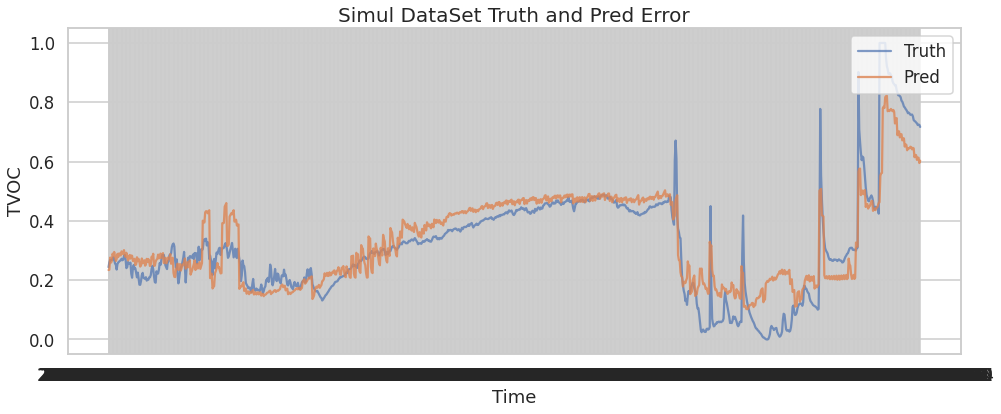

In [ ]:
# Simul DataSet Truth and Pred Error 
np.random.seed(42)
sample_idx = np.random.randint(1,simul_df.shape[0]-1000,1)[0]

plt.figure(figsize=(16,6))
sns.lineplot(og_simul.index[sample_idx:sample_idx+1000], og_simul['TVOC'][sample_idx:sample_idx+1000], alpha=0.7, label='Truth')
sns.lineplot(X_pred.index[sample_idx:sample_idx+1000], X_pred['TVOC'][sample_idx:sample_idx+1000], alpha=0.8, label='Pred')
plt.title('Simul DataSet Truth and Pred Error',size=20)
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Simul DataSet evaluation
lstm_ae_model.evaluate(X_simul_window,X_simul_window)

48/48 [==============================] - 2s 7ms/step - loss: 0.0230


0.022965772077441216

In [ ]:
# Distorted Classifier
print('Accuracy :',np.round(accuracy_score(y_label,np.array(['Normal','Outlier'])[np.zeros(y_label.shape[0]).astype(int)]),4))

Accuracy : 0.9738


Accuracy : 0.7992


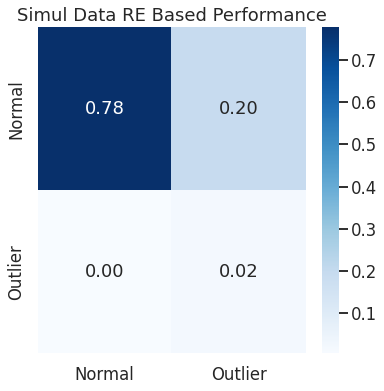

In [ ]:
# Reconstruction Error Based Outlier Detection Performance Evaluation
print('Accuracy :',np.round(accuracy_score(y_label,RE_score['RE_label']),4))
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_label,RE_score['RE_label'], normalize='all'), annot=True, cmap='Blues', fmt='.2f', xticklabels=['Normal','Outlier'], yticklabels=['Normal','Outlier'])
plt.title('Simul Data RE Based Performance')
plt.show()

In [ ]:
# get_clf_eval in RE_SCORE
y_test = (y_label == 'Outlier').astype(int)
re_pred = (RE_score['RE_label'] == 'Outlier').astype(int)

get_clf_eval(y_test,re_pred)

[[3563  898]
 [  22   98]]
정확도 :0.7992, 정밀도 :0.0984, 재현율 :0.8167, F1 :0.1756


## 4. Simulation Data Latent Feature Clustering

In [ ]:
# Embedding Simul Dataset by Encoder
SVM_score = pd.DataFrame(encoder.predict(X_simul_window).reshape(-1,4))
print('SVM_score.shape :',SVM_score.shape)
SVM_score.head(1)

SVM_score.shape : (4581, 4)


,0,1,2,3
0,2.128758,1.651871,2.837199,2.42906


In [ ]:
# Rename Prior Component for Clustering
SVM_score = SVM_score.iloc[:,[0,2]].rename(columns={0:'comp1',2:'comp2'})
SVM_score.index = og_simul.index
print('SVM_score.shape :',SVM_score.shape)
SVM_score.head()

SVM_score.shape : (4581, 2)


,comp1,comp2
Time,,
2022-07-13 0:01,2.128758,2.837199
2022-07-13 0:03,2.128758,2.837199
2022-07-13 0:05,2.128758,2.837199
2022-07-13 0:07,1.204974,2.512901
2022-07-13 0:09,1.204974,2.512901


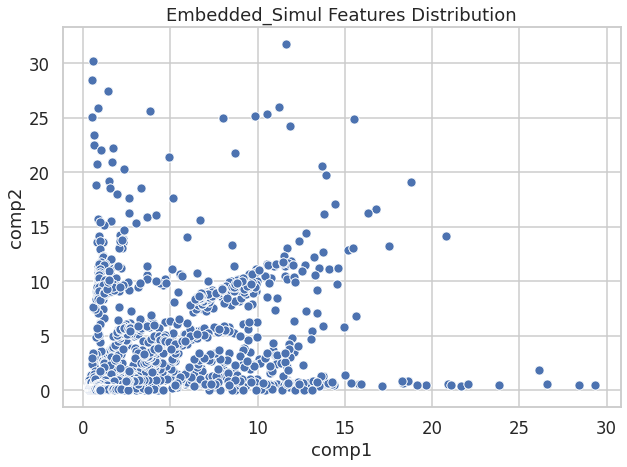

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Embedded_Simul Features Distribution')
sns.scatterplot(SVM_score.iloc[:,0], SVM_score.iloc[:,1], cmap=plt.get_cmap('Paired'))
# plt.xlim(0,25)
# plt.ylim(0,50)
plt.show()

## 5. Simulation Data OC-SVM Prediction

In [ ]:
# OC-SVM Model Load
filename = 'oc_svm_model_save/OC-SVM_model.sav'
oc_svm = pickle.load(open(filename, 'rb'))

In [ ]:
# OC-SVM Prediction
SVM_score['SVM_label'] = oc_svm.predict(SVM_score[['comp1','comp2']])
SVM_score['SVM_label'] = np.array(['Normal','Normal','Outlier'])[SVM_score['SVM_label'].values]
print(SVM_score['SVM_label'].value_counts())
SVM_score.head(1)

Normal     4554
Outlier      27
Name: SVM_label, dtype: int64


,comp1,comp2,SVM_label
Time,,,
2022-07-13 0:01,2.128758,2.837199,Normal


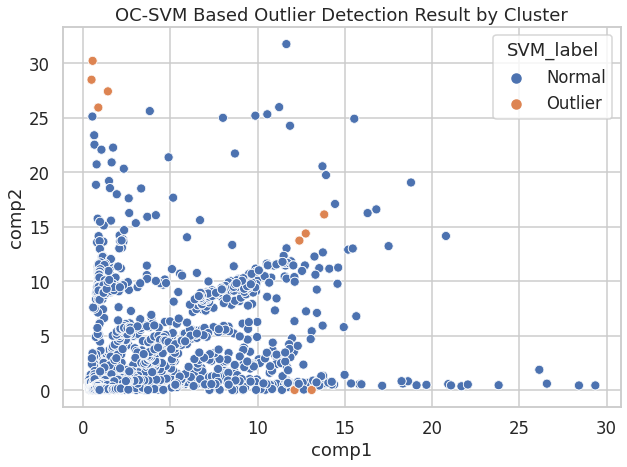

In [ ]:
# OC-SVM Based Outlier Detection Result by Clustering
plt.figure(figsize=(10,7))
plt.title('OC-SVM Based Outlier Detection Result by Cluster')
sns.scatterplot(SVM_score['comp1'], SVM_score['comp2'], hue=SVM_score['SVM_label'],cmap=plt.get_cmap('Paired'))
# plt.xlim(0,25)
# plt.ylim(0,50)
plt.show()

In [ ]:
# RE Based Outlier Distribution : TVOC
fig = px.scatter(x=simul_df.index, y=simul_df['TVOC'], title='SVM Based Outlier Distribution : TVOC', color=SVM_score['SVM_label'])
fig

Accuracy : 0.9683


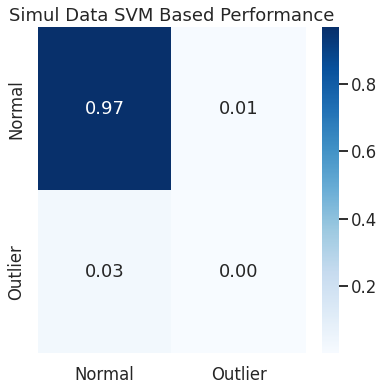

In [ ]:
# OC-SVM Based Outlier Detection Performance Evaluation
print('Accuracy :',np.round(accuracy_score(y_label,SVM_score['SVM_label']),4))
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_label,SVM_score['SVM_label'], normalize='all'), annot=True, cmap='Blues', fmt='.2f', xticklabels=['Normal','Outlier'], yticklabels=['Normal','Outlier'])
plt.title('Simul Data SVM Based Performance')
plt.show()

In [ ]:
# get_clf_eval in SVM_SCORE
y_test = (y_label == 'Outlier').astype(int)
svm_pred = (SVM_score['SVM_label'] == 'Outlier').astype(int)

get_clf_eval(y_test,svm_pred)

[[4435   26]
 [ 119    1]]
정확도 :0.9683, 정밀도 :0.0370, 재현율 :0.0083, F1 :0.0136


## 6. Decision Rule & Voting Classifier

In [ ]:
# Total Score DataFrame Definition
Total_score = pd.concat([RE_score,SVM_score],axis=1)
Total_score.head()

,RE_SCORE,Threshold,RE_label,comp1,comp2,SVM_label
Time,,,,,,
2022-07-13 0:01,0.007672,0.0315,Normal,2.128758,2.837199,Normal
2022-07-13 0:03,0.007396,0.0315,Normal,2.128758,2.837199,Normal
2022-07-13 0:05,0.027073,0.0315,Normal,2.128758,2.837199,Normal
2022-07-13 0:07,0.022548,0.0315,Normal,1.204974,2.512901,Normal
2022-07-13 0:09,0.025388,0.0315,Normal,1.204974,2.512901,Normal


In [ ]:
# Hard Voter Classifier : AND
Total_score['Hard Voter AND'] = ((Total_score['RE_label'] == 'Outlier') & (Total_score['SVM_label'] == 'Outlier')).astype(int)
Total_score['Hard Voter AND'].value_counts()

0    4559
1      22
Name: Hard Voter AND, dtype: int64

In [ ]:
# Hard Voter Classifier : OR
Total_score['Hard Voter OR'] = ((Total_score['RE_label'] == 'Outlier') | (Total_score['SVM_label'] == 'Outlier')).astype(int)
Total_score['Hard Voter OR'].value_counts()

0    3580
1    1001
Name: Hard Voter OR, dtype: int64

In [ ]:
Total_score.head(4)

,RE_SCORE,Threshold,RE_label,comp1,comp2,SVM_label,Hard Voter AND,Hard Voter OR
Time,,,,,,,,
2022-07-13 0:01,0.007672,0.0315,Normal,2.128758,2.837199,Normal,0,0
2022-07-13 0:03,0.007396,0.0315,Normal,2.128758,2.837199,Normal,0,0
2022-07-13 0:05,0.027073,0.0315,Normal,2.128758,2.837199,Normal,0,0
2022-07-13 0:07,0.022548,0.0315,Normal,1.204974,2.512901,Normal,0,0
